# Obtaining Learning curves for programming language in Stackoverflow

In [2]:
#Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import Tables

In [17]:
RanswersTable = pd.read_csv("r_answers.csv")
RquestionsTable = pd.read_csv("r_questions.csv")
JAVAanswersTable = pd.read_csv("java_answers.csv")
JAVAquestionsTable = pd.read_csv("java_questions.csv")
#PYTanswersTable = pd.read_csv("python_answers.csv")
#PYTquestionsTable=pd.read_csv("python_questions.csv")

C:\Users\baren\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Task 1 - Compute Probabilities of answers getting accpeted for each users at several time points.

In [18]:
def addProbAcceptedAnswerToTable(answersTable_provided,questionsTable_provided):
    
    answersTable=answersTable_provided.copy()
    questionsTable=questionsTable_provided.copy()
    answersTable=answersTable.sort_values([' OwnerUserId',' CreationDate']) #order by user and then by creation date
    questionsTable=questionsTable.sort_values([' OwnerUserId',' CreationDate']) #order by user and then by creation date
    
    #Find answers that were accepted (note that this information is in questions table)
    accepted=pd.match(answersTable["Id"].tolist(),questionsTable[' AcceptedAnswerId'])
    
    #Update answersTable with infor regarding whether answer was the accepted one or not.
    answersTable["AcceptedAnswer"]=accepted
    answersTable['AcceptedAnswer'] = np.where(answersTable['AcceptedAnswer'] == -1,0, answersTable['AcceptedAnswer'])
    answersTable['AcceptedAnswer'] = np.where(answersTable['AcceptedAnswer'] != 0,1, answersTable['AcceptedAnswer'])
    
    #Compute cumulative sum of accepted answers so far.
    answersTable['CumSumAccepted'] = answersTable.groupby(' OwnerUserId')['AcceptedAnswer'].cumsum()

    #Compute number of questions answered so far.
    answersTable['CumSumQuestions'] = answersTable.groupby(' OwnerUserId').cumcount() + 1

    #Compute prob of accepted answer
    answersTable['ProbAccAnswer'] = answersTable['CumSumAccepted']/answersTable['CumSumQuestions']
    
    return(answersTable)
 

In [19]:
#Compute probabilities of answer getting accepted for R, JAVA and Python
RanswersTable = addProbAcceptedAnswerToTable(RanswersTable,RquestionsTable)
JAVAanswersTable = addProbAcceptedAnswerToTable(JAVAanswersTable,JAVAquestionsTable)

#Make sure that questions table is also sorted
RquestionsTable=RquestionsTable.sort_values([' OwnerUserId',' CreationDate']) #order by user and then by creation date
JAVAquestionsTable=JAVAquestionsTable.sort_values([' OwnerUserId',' CreationDate']) #order by user and then by creation date


C:\Users\baren\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.match() is deprecated and will be removed in a future version
  if __name__ == '__main__':


## Task2 - Identify First Activity for each User

In [20]:
def gettingTableUserFirstActivity(answersTable,questionsTable):
    #"Normalization": 0 should correspond to time of first activity so that time is read as days after first activity
    #Correcting format of dates in the table
    answersTable[' CreationDate']=pd.to_datetime(answersTable[' CreationDate'])
    questionsTable[' CreationDate']=pd.to_datetime(questionsTable[' CreationDate'])
    
    #2 create relativeTime
    #2.1 identify the first activity of users
    answersTable["FirstActivity"]=~answersTable[" OwnerUserId"].duplicated()
    questionsTable["FirstActivity"]=~questionsTable[" OwnerUserId"].duplicated()
    
    #obtaining first answer and first question of a user
    firstAnswers=answersTable.loc[answersTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]
    firstQuestions = questionsTable.loc[questionsTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]
    
    #and merge them into one table
    firstActTable=firstQuestions.merge(firstAnswers, left_on=" OwnerUserId", right_on=" OwnerUserId", how='outer')
    firstActTable.columns = [" OwnerUserId","FirstQuestion","FirstAnswer"]
    
    #obtain first activity (either answer or question)
    firstActTable["FirstActivity"]=firstActTable[["FirstQuestion","FirstAnswer"]].min(axis=1)
    
    return(firstActTable)

In [10]:
RfirstActTable = gettingTableUserFirstActivity(RanswersTable,RquestionsTable)
JAVAfirstActTable = gettingTableUserFirstActivity(JAVAanswersTable,JAVAquestionsTable)

ValueError: Unknown string format

In [11]:
JAVAanswersTable[' CreationDate']=pd.to_datetime(JAVAanswersTable[' CreationDate'],errors="coerce")

In [12]:
JAVAanswersTable[JAVAanswersTable[" CreationDate"].isnull()]

,Id,OwnerUserId,CreationDate,LastActivityDate,Score,ParentId,CommentCount,AcceptedAnswer,CumSumAccepted,CumSumQuestions,ProbAccAnswer
1649881,32307800,1126804,NaT,2015-08-31T09:50:09.297,5,32280824,0,0,0,1,0.0


In [13]:
JAVAquestionsTable[' CreationDate']=pd.to_datetime(JAVAquestionsTable[' CreationDate'],errors="coerce")

In [14]:
JAVAquestionsTable[JAVAquestionsTable[" CreationDate"].isnull()]

,Id,OwnerUserId,CreationDate,LastActivityDate,Score,AcceptedAnswerId,AnswerCount,CommentCount,ViewCount,FavoriteCount
321300,13904061,1207659,NaT,2012-12-16T20:41:07.810,3,13905179,1,13,5697,1


## Task 3 Obtain normalized time for x axis

In [21]:
def obtainSummaryProbAccAnswer(answersTable,questionsTable,firstActTable):
    #Correcting format of dates in the table
    answersTable[' CreationDate']=pd.to_datetime(answersTable[' CreationDate'])
    questionsTable[' CreationDate']=pd.to_datetime(questionsTable[' CreationDate'])
    
    #Adding first activity table to answerstable 
    summaryTableProbAccAnswer = answersTable[["Id"," OwnerUserId"," CreationDate"," ParentId","ProbAccAnswer"]]
    summaryTableProbAccAnswer=summaryTableProbAccAnswer.merge(firstActTable,left_on = " OwnerUserId",right_on=" OwnerUserId")
    
    #Use first activity to obtain normalized time
    summaryTableProbAccAnswer["Present"]= max(summaryTableProbAccAnswer[" CreationDate"])
    #timestamp of answer compared to first activity of that user
    summaryTableProbAccAnswer["DifferenceNumerator"]=(summaryTableProbAccAnswer[" CreationDate"]-summaryTableProbAccAnswer["FirstActivity"])
    summaryTableProbAccAnswer["DifferenceDenominator"]=(summaryTableProbAccAnswer["Present"]-summaryTableProbAccAnswer["FirstActivity"])
    
    summaryTableProbAccAnswer.DifferenceNumerator=summaryTableProbAccAnswer.DifferenceNumerator.dt.total_seconds() /(24*3600) # to obtain days with decimals
    summaryTableProbAccAnswer.DifferenceDenominator=summaryTableProbAccAnswer.DifferenceDenominator.dt.total_seconds()/(24*3600)
    summaryTableProbAccAnswer["NormTime"]=summaryTableProbAccAnswer["DifferenceNumerator"]/summaryTableProbAccAnswer["DifferenceDenominator"]
    
    return(summaryTableProbAccAnswer)

In [22]:
RsummaryTableProbAccAnswer = obtainSummaryProbAccAnswer(RanswersTable,RquestionsTable,RfirstActTable)
JAVAsummaryTableProbAccAnswer = obtainSummaryProbAccAnswer(JAVAanswersTable,JAVAquestionsTable,JAVAfirstActTable)

## Task3 Remove users with less than 5 answers

In [25]:
#Remove users who have less than 5 answers
def removeUsersWithFewAnswers(answersTable,summaryTableProbAccAnswer):
    nrQuestionsperUser = answersTable[" OwnerUserId"].value_counts()
    lessthan5users=nrQuestionsperUser[nrQuestionsperUser<5].index
    nrUsersBefore=len(list(set(summaryTableProbAccAnswer[" OwnerUserId"].tolist())))
    filteredTable=summaryTableProbAccAnswer.loc[~summaryTableProbAccAnswer[" OwnerUserId"].isin(lessthan5users)]
    nrUsersAfter=len(list(set(filteredTable[" OwnerUserId"].tolist())))
    print(1-nrUsersAfter/nrUsersBefore,"% of the users were removed.")
    return(filteredTable)

In [26]:
RsummaryTableProbAccAnswer = removeUsersWithFewAnswers(RanswersTable,RsummaryTableProbAccAnswer)

0.8437442133201654 % of the users were removed.


In [ ]:
JAVAsummaryTableProbAccAnswer = removeUsersWithFewAnswers(JAVAanswersTable,JAVAsummaryTableProbAccAnswer)

## Task4 Prolong data until 0 timepoint, for the cases in which first activity is a question

In [28]:
def addZeroTimepoint(summaryTableProbAccAnswer_provided):
    summaryTableProbAccAnswer=summaryTableProbAccAnswer_provided.copy()
    #Add 0 to time 0
    usersWhoHaveZero=list(set(summaryTableProbAccAnswer[" OwnerUserId"][summaryTableProbAccAnswer["NormTime"]==0].tolist()))
    usersArtificialZero = list(set(summaryTableProbAccAnswer[" OwnerUserId"][~summaryTableProbAccAnswer[" OwnerUserId"].isin(usersWhoHaveZero)].tolist()))
    tempdfArtificialZero = pd.DataFrame(0, index=np.arange(len(usersArtificialZero)), columns=list(summaryTableProbAccAnswer.columns.values))
    tempdfArtificialZero[" OwnerUserId"]=usersArtificialZero
    tempdfArtificialZero[" OwnerUserId"]=tempdfArtificialZero[" OwnerUserId"].astype(np.int64) # make type correct
    summaryTableProbAccAnswer = summaryTableProbAccAnswer.append(tempdfArtificialZero, ignore_index=True)

    #reorder again
    summaryTableProbAccAnswer=summaryTableProbAccAnswer.sort_values([' OwnerUserId','NormTime']) #order by user
    return(summaryTableProbAccAnswer)

In [29]:
RsummaryTableProbAccAnswer = addZeroTimepoint(RsummaryTableProbAccAnswer)

In [30]:
JAVAsummaryTableProbAccAnswer = addZeroTimepoint(JAVAsummaryTableProbAccAnswer)

,Id,OwnerUserId,CreationDate,ParentId,ProbAccAnswer,FirstQuestion,FirstAnswer,FirstActivity,Present,DifferenceNumerator,DifferenceDenominator,NormTime
252282,0,0,0,0,0.000000,0,0,0,0,0.000000,0.000000,0.000000
0,79788,0,2008-09-17 03:51:30.190000,79709,0.000000,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,0.008487,3462.026488,0.000002
1,86804,0,2008-09-17 19:39:37.370000,79709,0.000000,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,0.666903,3462.026488,0.000193
2,476928,0,2009-01-25 00:05:19.107000,476726,0.000000,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,129.851414,3462.026488,0.037507
3,501926,0,2009-02-02 00:42:27.250000,501917,0.000000,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,137.877203,3462.026488,0.039826
4,612573,0,2009-03-04 21:41:41.980000,596819,0.000000,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,168.751679,3462.026488,0.048744
5,750852,0,2009-04-15 08:58:03.103000,750786,0.000000,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,210.221368,3462.026488,0.060722
6,823251,0,2009-05-05 03:50:25.733000,750786,0.000000,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,230.007741,3462.026488,0.066437
7,876778,0,2009-05-18 08:56:02.270000,876711,0.000000,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,243.219969,3462.026488,0.070254
8,969680,0,2009-06-09 12:03:40.747000,750786,0.111111,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,265.350276,3462.026488,0.076646


## Task 5 Plot Evolution of 6 random users

In [34]:
import random
def plotEvolutionRandomUsers(summaryTableProbAccAnswer,language):
    r_users=summaryTableProbAccAnswer.loc[np.random.choice(summaryTableProbAccAnswer.index, 6)][" OwnerUserId"].tolist()
    plt.figure(figsize=(12,8))

    for i in range(0,6):
        user=r_users[i]
        plt.subplot(3,2,i+1)
        plt.xlabel("Days since first activity in "+language)
        plt.ylabel("Probability of answer\ngetting accepted")
        plt.plot(summaryTableProbAccAnswer.loc[summaryTableProbAccAnswer[" OwnerUserId"]==user]["DifferenceNumerator"].tolist(),summaryTableProbAccAnswer.loc[summaryTableProbAccAnswer[" OwnerUserId"]==user]["ProbAccAnswer"].tolist())
    
    plt.tight_layout()
    plt.show()

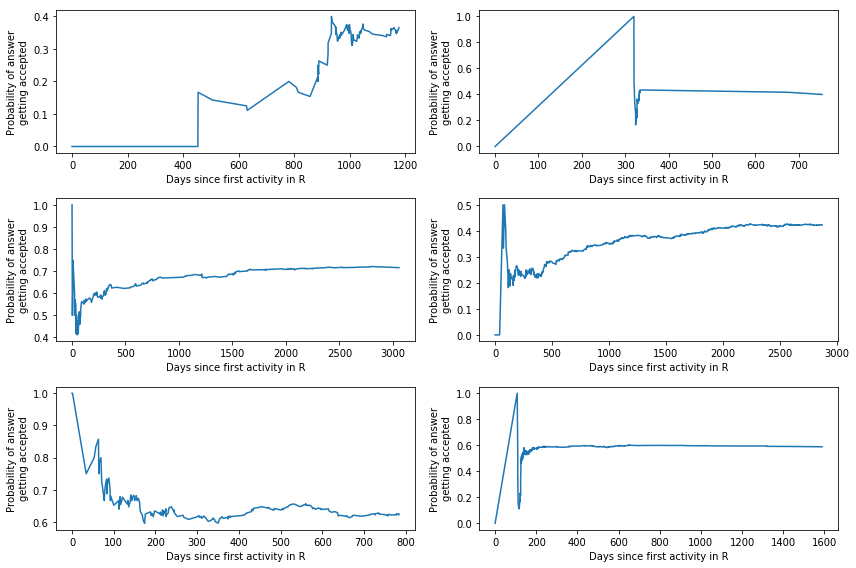

In [35]:
plotEvolutionRandomUsers(RsummaryTableProbAccAnswer,"R")

## Task 7 - Aggregation of all individual learning curves into one 

In [37]:
#Import some modules
import numpy as np
from scipy.interpolate import interp1d

In [44]:
def aggregateIndividualLearningCurves(summaryTableProbAccAnswer,thresExpertise,threshUsers,language):
    #possible timepoints from 0 to the maximum span.
    x_all = np.linspace(0, max(summaryTableProbAccAnswer["DifferenceDenominator"]),num=5000, endpoint=True)
    
    #variable initialization
    sumProbs = np.zeros(len(x_all))
    nrUsers = np.zeros(len(x_all))
    users = list(set(summaryTableProbAccAnswer[" OwnerUserId"].tolist()))

    consUsers=0 #considered users

    #for each user:
    #linear interpolation - already checked that curve shape is similar to the ones obtained individually
    for user in users:
        xs_user=summaryTableProbAccAnswer["DifferenceNumerator"][summaryTableProbAccAnswer[" OwnerUserId"]==user].tolist()
        probs_user= summaryTableProbAccAnswer["ProbAccAnswer"][summaryTableProbAccAnswer[" OwnerUserId"]==user].tolist()
        
        #interpolation function for this user
        f1 = interp1d(xs_user,probs_user ,'linear')
        
        # only interpolated values are considered, meaning no extrapolated values
        subset_x_all=x_all[x_all<max(xs_user)]
        f1_int = f1(subset_x_all)
    
        
        # only users that are considered to achieve expertise will be taken into consideration for computing the learning curve
        if (min(probs_user[-5:])>thresExpertise):
            consUsers=consUsers+1
       
            #update probability sums at each time point with the interpolated probabilities for this user
            sumProbs[0:len(subset_x_all)]=sumProbs[0:len(subset_x_all)]+f1_int
            #update nr users 
            nrUsers[0:len(subset_x_all)] = nrUsers[0:len(subset_x_all)]+1
    
    #Remove timepoints which have less than a threshold number of users
    noUsersPos = np.where(nrUsers>threshUsers)
    sumProbs=sumProbs[noUsersPos]
    nrUsers=nrUsers[noUsersPos]
    x_all=x_all[noUsersPos]
    
    probs=sumProbs/nrUsers
    
    print((len(users)-consUsers)/len(users), " were not considered")
    
    plt.figure()
    plt.xlabel("Days since first activity in " + language)
    plt.ylabel("Probability of answer\ngetting accepted")
    plt.plot(x_all, probs)
    plt.show()
    

0.6879320560932254  were not considered


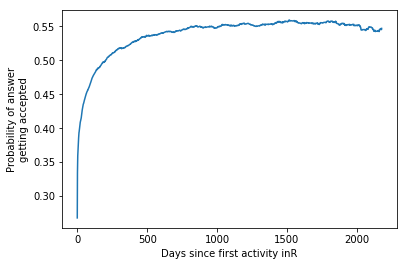

In [47]:
#R
aggregateIndividualLearningCurves(RsummaryTableProbAccAnswer,0.4,100,"R")